# Lab Part - Wrangle & Profile
In this lab part you will need to parse and join the data (Wrangle) and explore the data (Profile).

Description of the datasets, as well as the task at hand can be read in Lab Part 1

This notebook contains the following steps:
  * **Step -1: Setup** - Defining libraries, constants, reading raw data, etc...
  * **Step 0: Exploratory Data Analysis: Understand the Data** - Not specifically mentioned in this task. However, I feel that this is a necessary precondition before doing the other steps
  * **Step 1: Wrangle** - Goal is to parse and join datasets.
    * Openpowerlifting: This is the main data we are interested in, and therefore several steps are required
      * Filter columns:
        * 4th attempts are removed, as they are world records, and thus clearly outliers
        * ??
      * Filter Rows
        * All rows without lifters age will be removed, as this is a key metric in getting the average height
        * All rows with that can't give meaningful group statistics, as groups in `country` and/or `Sex` are too small, are removed
      * Cleanse:
        * Cleansing of stuff will likely be done
      * Augment columns:
        * Appending rows with calculated statistics such as Wilks
        * Surrogate keys: As we are joining on `Sex`, `Age`, `Country`, and `Year`, we need to ensure that data is shaped equally in both datasets
    * Height dataset: Will not wrangle this, but take the values here as ground truths instead.
    * **Join:** After specified wrangles have been done, we can simply join on the surrogate key columns. Done using left join, in order to validate that nothing is missing.
  * **Step 1.2 - Wrangle Bonus Attempt:** - Checking data quality
  * **Step 2 - Profile:** Looking for interesting insight
    * **Insight 1:** Development of strength results over time, and the reason behind it
    * **Insight 2:** Changes in height over time
    * **Insight 3:** Correlation between height, weight and performance
  
  
~~TODO: Why the heck does wilks apply wrongly?~~

## Step -1: Setup
This is quite a standard step. Here I'm loading in required libraries, defining where the data is stored, as well as defining helper functions used later

In [1]:
# Define a flag, whether Exploratory analysis should be shown in notebook. Not required for this task, and insights from it is already implemented, so only adds clutter
SHOW_EXPLORATOY_STEP = False

### Load Libraries

In [2]:
#!pip install missingno
#!pip install pycountry_convert

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # use seaborn plotting style

import datetime

import missingno as msno
import pycountry_convert as pc
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [4]:
pd.set_option('display.max_colwidth', None)

### Constants and Stuff

In [5]:
#Location of input files:
LIFTING_RAW_DATA_PATH = 'raw_data/openpowerlifting/openpowerlifting-2021-11-10-7d85ae9b.csv'
HEIGHT_RAW_DATA_PATH  = 'raw_data/NCD_RisC/NCD_RisC_Lancet_2020_height_child_adolescent_country.csv'

# Outputs
OUTPUT_FOLDER = 'output'
OUTPUT_DATASET = OUTPUT_FOLDER + '/' + 'consolidated_dataset.csv'

#### Class for logging which steps take time

In [6]:
class Duration_Log:
    
    def __init__(self):
        self.time_log = pd.DataFrame(columns = ['Stepname', 'start', 'end', 'duration'])
    
    def add_step(self, step_name, start_or_stop = 'start'):
        #Do asserts here
        time = datetime.datetime.now()
        if start_or_stop == 'start':
            self.time_log = self.time_log.append(pd.DataFrame([[step_name,time,None,None]], columns=self.time_log.columns))
        if start_or_stop == 'stop':
            mask = self.time_log.Stepname == step_name
            start = self.time_log.loc[mask, 'start'].item()
            duration = time - start
            self.time_log[mask] = pd.DataFrame([[step_name,start,time,duration]], columns=self.time_log.columns)
            
    def show_log(self):
        return self.time_log
    
    def get_entry(self, step_name):
        return self.time_log.loc[self.time_log.Stepname == step_name, 'start'].item()
        
        
duration_log = Duration_Log()

#### Calculate Willks score

In [7]:
def calculate_Wilks(gender, bodyweight, liftedweight, rule_2020 = False):
    #Constants 
    x = bodyweight # shortcut, as formula gets long otherwise
    enumerator = 500
    if gender == 'M':
        a = -216.0475144
        b = 16.2606339
        c = -0.002388645
        d = -0.00113732
        e = 7.01863e-06
        f = -1.291e-08
    if gender == 'F':
        a = 594.31747775582 
        b = -27.23842536447 
        c = 0.82112226871 
        d = -0.00930733913 
        e = 4.731582e-05 
        f = -9.054e-08 
    # 2020 fix    
    if rule_2020:
        enumerator = 600
        if gender == 'M':
            a = 47.46178854
            b = 8.472061379
            c = 0.07369410346
            d = -0.001395833811
            e = 7.07665973070743e-06
            f = -1.20804336482315e-08
        if gender == 'F':
            a = -125.4255398 
            b = 13.71219419 
            c = -0.03307250631 
            d = -0.001050400051 
            e = 9.38773881462799e-05 
            f = -2.3334613884954e-08 
    
    # Split into smaller parts due to floating point handling
    ax = a
    bx = b*x
    cx = c*(x**2)
    dx = d*(x**3)
    ex = e*(x**4)
    fx = f*(x**5)
    
    denominator = ax + bx + cx + dx + ex + fx
    Coeff = enumerator/(denominator)
    score = Coeff * liftedweight
    return score
    
# Test
res = calculate_Wilks('M', 81.5, (177.5+120+215), False)
print(res)
# Should return 345.87

345.8701943613629


#### Get continent of country

In [8]:
def get_continent(country_name):
    if (country_name == 'China (Hong Kong SAR)'):
        country_name = 'China'
    if (country_name == 'DR Congo'):
        country_name = 'Congo'
   
    # Didn't know there were so many... should have gone with a switch statement
    if country_name == "Cote d'Ivoire":
        country_code = 'CI'
    elif country_name == 'Guinea Bissau':
        country_code = 'GW'
    elif country_name == 'Lao PDR':
        country_code = 'LA'
    elif country_name == 'Macedonia (TFYR)':
        country_code = 'MK'
    elif country_name == 'Micronesia (Federated States of)':
        country_code = 'FM'
    elif country_name == 'Occupied Palestinian Territory':
        country_code = 'PS'
    else: 
        country_code = pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
    
    
    if country_code == 'TL':
        continent_name = 'Asia'
    else:        
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
    return continent_name

### Read in raw data

In [9]:
# Openpowerlifting
duration_log.add_step('Read in Openpowerlifting CSV', 'start')
Lifting_Data_Raw = pd.read_csv(LIFTING_RAW_DATA_PATH)
duration_log.add_step('Read in Openpowerlifting CSV', 'stop')
Lifting_Data_Raw_shape = Lifting_Data_Raw.shape
print(f'Duration: {str(duration_log.get_entry("Read in Openpowerlifting CSV"))}. Read in Openpowerlifting data. Shape of data: {str(Lifting_Data_Raw_shape)}')

# Country-Specific Evolution of adult height over time
duration_log.add_step('Read in height CSV', 'start')
Height_Data_Raw = pd.read_csv(HEIGHT_RAW_DATA_PATH)
duration_log.add_step('Read in height CSV', 'stop')
Height_Data_Raw_shape = Height_Data_Raw.shape
print(f'Duration: {str(duration_log.get_entry("Read in height CSV"))}. Read in height data. Shape of data: {str(Lifting_Data_Raw_shape)}')

/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (33,35,38) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Duration: 2021-12-19 14:27:11.469988. Read in Openpowerlifting data. Shape of data: (2554233, 41)
Duration: 2021-12-19 14:27:18.334284. Read in height data. Shape of data: (2554233, 41)


## Step 0 Understand the data
Before doing any preprocessing, I'd like to get to know the data a bit better. This includes tasks such as:
  * Understand which columns are in; and what they mean
  * See distribution of missing values
  * Do some grouping and counting, to see the hierachies

In [10]:
duration_log.add_step('Exploratory Data Analysis - Openpowerlifting', 'start')

#### Openopwerlifting Data
This dataset is very well documented on https://openpowerlifting.gitlab.io/opl-csv/bulk-csv-docs.html. Nonetheless, I would still like to get some feel for the data it contains

##### Which columns does it contain

In [11]:
if SHOW_EXPLORATOY_STEP:
    Lifting_Data_Raw.columns

In [12]:
if SHOW_EXPLORATOY_STEP:
    Lifting_Data_Raw.groupby('Sex').count()

In [13]:
if SHOW_EXPLORATOY_STEP:
    Lifting_Data_Raw.groupby('Equipment').count()

In [14]:
if SHOW_EXPLORATOY_STEP:
    Lifting_Data_Raw.groupby(['MeetCountry', 'MeetState', 'MeetTown', 'MeetName']).count()

In [15]:
duration_log.add_step('Exploratory Data Analysis - Openpowerlifting', 'stop')

### Height Data

In [16]:
duration_log.add_step('Exploratory Data Analysis - Height', 'start')

#### Which columns does it contain?

In [17]:
if SHOW_EXPLORATOY_STEP:
    Height_Data_Raw.columns

#### See if the intervals covers all expected values

In [18]:
if SHOW_EXPLORATOY_STEP:
    Height_Data_Raw.groupby('Country').agg({'Year': ['min', 'max']
                                      , 'Age group': ['min', 'max']})

In [19]:
duration_log.add_step('Exploratory Data Analysis - Height', 'stop')

## Step 1: Wrangle
**Goal: Parse and join datasets.**

In the _Wrangle_ stage you will need to join the datasets you found in the Discover stage.

At the end you shall come up with a new, larger, and refined dataset which you will use in the next stage.

#### Stuff I will? still to do:
* Height:

* Openpowerlifting:
  * Filter out people with failed attemps
  * Calculate Wilks
  * Calculate Dots
  * Filter out people with missing:
    * Age
    * Weight
    * Federation?
    * No valid competitions
  * Remove Columns:
    * Fourth attempt (We are interested in populations. People with 4th attempts set world records, and are thus outliers (and likely shorter than average)
  * Should we skip equipped?
  * Calculate birthyear estimate
  * Create column with "Expected average height"; meaning joining on:
    * Country
    * Gender
    * Birthyear
    * Age (If old, assume same height as when 18)



### Openpowerlifting Dataset

#### Setup

In [20]:
duration_log.add_step('Wrangle OPL - Clone', 'start')
Lifting_Data_Filtered = Lifting_Data_Raw.copy()
duration_log.add_step('Wrangle OPL - Clone', 'stop')
print(Lifting_Data_Filtered.shape)

(2554233, 41)


#### Filter out non-needed columns

In [21]:
## Dropping 4th attemps. These are only when new world records are set, and are thus population outliers
duration_log.add_step('Wrangle OPL - drop 4th attempts', 'start')
Lifting_Data_Filtered.drop(['Squat4Kg', 'Bench4Kg', 'Deadlift4Kg'], axis=1, inplace = True)
duration_log.add_step('Wrangle OPL - drop 4th attempts', 'stop')
print(Lifting_Data_Filtered.shape)

(2554233, 38)


#### Filter out non-needed rows

In [22]:
## As Age is one of the defining metrics in the analysis, lifters without age will be discarded.
duration_log.add_step('Wrangle OPL - drop missing age', 'start')
Lifting_Data_Filtered.dropna(subset=['Age'], inplace = True)
duration_log.add_step('Wrangle OPL - drop missing age', 'stop')
print(Lifting_Data_Filtered.shape)

(1583310, 38)


#### Filter out rows, where groups are too small to make population analytics

In [23]:
# Filter out "non-traditional" genders. Reason being This is an attempt to correlate average height, and I don't know how to handle non-binary height averages. Could average both genders in height dataset. However with only 22 people, this is still too small a population
duration_log.add_step('Wrangle OPL - filter sex', 'start')
Lifting_Data_Filtered = Lifting_Data_Filtered.groupby('Sex').filter(lambda x: len(x) >= 100)
duration_log.add_step('Wrangle OPL - filter sex', 'stop')
print(Lifting_Data_Filtered.shape)

# Filter out countries with too low population of lifters
duration_log.add_step('Wrangle OPL - filter Country', 'start')
Lifting_Data_Filtered = Lifting_Data_Filtered.groupby('Country').filter(lambda x: len(x) >= 500)
duration_log.add_step('Wrangle OPL - filter Country', 'stop')
print(Lifting_Data_Filtered.shape)

# Show only SBD events?
# Reason being it is easier to judge uniform strength then - Decided against it - Can be filter in visualization

# Filter "Bombed out attemps"
## If a person gets three failed attemps at any one lift (represented as negative values), The lifter gets disqualified.
## I've decided to remove these attempts, as they are not a good indicator for what strength the lifter had at the certain timepoint
mask = (Lifting_Data_Filtered.Best3SquatKg > 0) & (Lifting_Data_Filtered.Best3BenchKg > 0) & (Lifting_Data_Filtered.Best3DeadliftKg > 0)
Lifting_Data_Filtered['Valid_Results'] = mask
## Decided to skip this step, but instead flag it in the visualization
#Lifting_Data_Filtered = Lifting_Data_Filtered[mask]

(1583296, 38)
(1153646, 38)


##### Wilks Score
A measure for comparing strength across weightclasses and genders.
Description: https://en.wikipedia.org/wiki/Wilks_coefficient

(Also: Find better source for description)

In [24]:
duration_log.add_step('Wrangle OPL - Add Wilks Old', 'start')
Lifting_Data_Filtered['Wilks_Old'] = Lifting_Data_Filtered.apply(lambda x: calculate_Wilks(x.Sex, x.BodyweightKg, x.TotalKg, True), axis=1)
duration_log.add_step('Wrangle OPL - Add Wilks Old', 'stop')
duration_log.add_step('Wrangle OPL - Add Wilks 2020', 'start')
Lifting_Data_Filtered['Wilks_2020'] = Lifting_Data_Filtered.apply(lambda x: calculate_Wilks(x.Sex, x.BodyweightKg, x.TotalKg, True), axis=1)
duration_log.add_step('Wrangle OPL - Add Wilks 2020', 'stop')

In [25]:
if SHOW_EXPLORATOY_STEP:
    Lifting_Data_Filtered[['Name', 'Sex', 'Age', 'Division', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg', 'Wilks', 'Wilks_Old', 'Wilks_2020']]

#### Consolidate Country names
As the datasets have different names/spellings, we need to ensure that the countries can be joined on.
It is also likely that not all small countries show up in both datasets, which needs to be handled separately.
**Possibilities:**
  * Rename countries where it is obvious
  * Remove small countries
  * aggregate height for some method. Maybe average per neighbouring country?

##### See which lifter countries can't be linked up

In [26]:
# Could be done in a nicer way, but this works

duration_log.add_step('Wrangle OPL - Check mismatched countries', 'start')

# Find unique countries in both datasets
## Figure out distinct countries in Height dataset, and add a flag to show it exists after a join
height_countries = pd.DataFrame({'Country' : Height_Data_Raw['Country'].unique()})
height_countries['Exists_In_Heights'] = 'Y'

## Count distinct lifters in each country in the filtered dataset
lifting_countries_filtered = Lifting_Data_Filtered.groupby('Country').Name.nunique().reset_index()
lifting_countries_filtered.rename(columns={ lifting_countries_filtered.columns[1]: "count_filtered_lifters" }, inplace = True)

## Count distinct lifters in each country in the raw dataset
lifting_countries_raw = Lifting_Data_Raw.groupby('Country').Name.nunique().reset_index()
lifting_countries_raw.rename(columns={ lifting_countries_raw.columns[1]: "count_raw_lifters" }, inplace = True)

# Concatenate all to a single list
all_countries = pd.concat([height_countries, lifting_countries_filtered, lifting_countries_raw])
all_countries['Country'].unique()
all_countries = pd.DataFrame({'Country' : all_countries['Country'].unique()})
all_countries = all_countries.sort_values('Country')

# Merge to one lookup dataset
all_countries = pd.merge(all_countries, lifting_countries_filtered, on='Country', how='outer')
all_countries = pd.merge(all_countries, lifting_countries_raw, on='Country', how='outer')
all_countries = pd.merge(all_countries, height_countries, on='Country', how='outer')

# Show problematic Countries:
pd.set_option('display.max_rows', all_countries.shape[0]+1)
problematic_Countries = all_countries.loc[(all_countries['count_filtered_lifters'].notnull()) & (all_countries['Exists_In_Heights'].isnull())]

print('Countries with no matching height')
display(problematic_Countries)

if SHOW_EXPLORATOY_STEP:
    print('Displaying all countries, and manually trying to lookup the missing values')
    all_countries
    
duration_log.add_step('Wrangle OPL - Check mismatched countries', 'stop')

Countries with no matching height


,Country,count_filtered_lifters,count_raw_lifters,Exists_In_Heights
54,Czechia,1521.0,1602.0,NaN
65,England,2972.0,8902.0,NaN
91,Hong Kong,240.0,252.0,NaN
168,Russia,40447.0,41189.0,NaN
177,Scotland,776.0,1233.0,NaN
216,UK,1910.0,2426.0,NaN
218,USA,111969.0,131305.0,NaN
219,USSR,361.0,395.0,NaN


**Intermediary Conclusion:**
We see that the countries that have missing entries are:
  * **USSR** and **Russia**: Are both under **Russian Federation** In height dataset
  * **England**, **N.Ireland**, **Scotland**, **UK**, and **Wales**: Is all under **United Kingdom** in Height dataset
  * **USA**: Is un-abreviated to **United States of America** in Height dataset
  * **Hong Kong**: Is grouped in **China (Hong Kong SAR)**
  * **Czechia**: is classified under **Czech Republic**
  
Knowing this, I'm augmenting an additional column to the lifter dataset, which contains a surrogate key to height dataset:

In [27]:
duration_log.add_step('Wrangle OPL - Rename linking countries', 'start')
Lifting_Data_Filtered['Country_Linking'] = Lifting_Data_Filtered['Country'].copy()
Lifting_Data_Filtered['Country_Linking'].replace({"USSR":"Russian Federation"
                                                , "Russia":"Russian Federation"
                                                , "England":"United Kingdom"
                                                , "N.Ireland":"United Kingdom"
                                                , "Scotland":"United Kingdom"
                                                , "UK":"United Kingdom"
                                                , "Wales":"United Kingdom"
                                                , "USA":"United States of America"
                                                , "Hong Kong":"China (Hong Kong SAR)"
                                                , "Czechia":"Czech Republic"
                                                 }, inplace=True)

# Check if all countries are now matched - Hoping for no results returned
d = pd.merge(Lifting_Data_Filtered#['Country_Linking']
       , height_countries['Country'].drop_duplicates()
       , left_on='Country_Linking'
       , right_on='Country'
       , how='left'
       , indicator=True)


d.loc[d['_merge'] == 'left_only'].groupby('Country_Linking').count()

duration_log.add_step('Wrangle OPL - Rename linking countries', 'stop')

#### Add Continent to dataset

In [28]:
duration_log.add_step('Wrangle OPL - Add Continent', 'start')
Lifting_Data_Filtered['Continent'] = Lifting_Data_Filtered['Country_Linking'].apply(get_continent)
duration_log.add_step('Wrangle OPL - Add Continent', 'stop')

#### Consolidate Sex
* Sex is encoded differently in both datasets

In [29]:
duration_log.add_step('Wrangle OPL - Rename linking Sex', 'start')
# Rename sex to be consistant
Lifting_Data_Filtered['Sex_Linking'] = Lifting_Data_Filtered['Sex'].copy()
Lifting_Data_Filtered['Sex_Linking'].replace({"F":"Girls", "M":"Boys"}, inplace=True)
duration_log.add_step('Wrangle OPL - Rename linking Sex', 'stop')

#### Consolidate Ages and join
Next step is to figure out how to match Date and ages

Several steps need to be done:
* Competition year is a date in lifting dataset, and integer in height
* Ages of people is way higher in lifting dataset. So we need to do another estimate.
  * Hypothesis: People don't get taller after the age of 18 (Not stricktly true). We can therefore calculate at what year the person was 19, and join with corresponding year of height dataset, and assume a linking age of 19
  * Figure out what to do with fractional age - currently rounded. Could average the two surrounding years

In [30]:
duration_log.add_step('Wrangle OPL - consolidate year and age', 'start')
my = 19 #Max Year age - bad naming that got stuck.

# Calculate a naive year for linking - Will be updated later
Lifting_Data_Filtered['Competition_year'] = pd.DatetimeIndex(Lifting_Data_Filtered['Date']).year
Lifting_Data_Filtered['Year_Linking'] = pd.DatetimeIndex(Lifting_Data_Filtered['Date']).year

# Calculate the age of the lifter whn to join
Lifting_Data_Filtered['Age_Linking'] = round(Lifting_Data_Filtered['Age'].copy())
# Find lifters that are older than max in height dataset
ind = Lifting_Data_Filtered['Age'] > my
# Hard-cap them to oldest possible
Lifting_Data_Filtered.loc[ind, 'Age_Linking'] = my
# And figure out what year they were `my` years old
Lifting_Data_Filtered.loc[ind, 'Year_Linking'] = Lifting_Data_Filtered.loc[ind]['Year_Linking'] - (round(Lifting_Data_Filtered.loc[ind]['Age']) -my)
duration_log.add_step('Wrangle OPL - consolidate year and age', 'start')

##### Overwrite some stuff
As seen on the exploratory section, all countries in height dataset has years from 1985 to 2019, and ages from 5-19.
Therefore doing a final replace here.

Could/**Should** have done some interpolation for heights, as there is quite a lot being overwritten!

In [31]:
duration_log.add_step('Wrangle OPL - overwrite year and age', 'start')
mask = Lifting_Data_Filtered['Year_Linking'] > 2019
Lifting_Data_Filtered.loc[mask, 'Year_Linking'] = 2019
print(f'Overwrote years newer than 2019. Rows affected: {sum(mask)}')

mask = Lifting_Data_Filtered['Year_Linking'] < 1985
Lifting_Data_Filtered.loc[mask, 'Year_Linking'] = 1985
print(f'Overwrote years older than 1985. Rows affected: {sum(mask)}')

mask = Lifting_Data_Filtered['Age_Linking'] > 19
Lifting_Data_Filtered.loc[mask, 'Age_Linking'] = 19
print(f'Overwrote ages greater than 19.  Rows affected: {sum(mask)}')

mask = Lifting_Data_Filtered['Age_Linking'] < 5
Lifting_Data_Filtered.loc[mask, 'Age_Linking'] = 5
print(f'Overwrote ages less than 5.      Rows affected: {sum(mask)}')

duration_log.add_step('Wrangle OPL - overwrite year and age', 'stop')

Overwrote years newer than 2019. Rows affected: 23061
Overwrote years older than 1985. Rows affected: 187013
Overwrote ages greater than 19.  Rows affected: 0
Overwrote ages less than 5.      Rows affected: 153


#### Merge the data

In [32]:
duration_log.add_step('Wrangle - Join datasets', 'start')
consolidated_dataset = pd.merge(Lifting_Data_Filtered
                               , Height_Data_Raw
                               , left_on=['Country_Linking', 'Year_Linking', 'Sex_Linking', 'Age_Linking']
                               , right_on=['Country', 'Year', 'Sex', 'Age group']
                               , how='left'
                               , indicator=True
                              )
duration_log.add_step('Wrangle - Join datasets', 'stop')

##### Check how well we did:

In [33]:
if SHOW_EXPLORATOY_STEP:
    consolidate_dataset.groupby('_merge').count()

#### Select final columns, and save output
As we now have succesfully cleaned and merged the dataset, I'm keeping only relevant columns, and saving the result to output

In [34]:
duration_log.add_step('Wrangle - select, rename and reorder', 'start')
# Select relevant columns (and reorder)
consolidated_dataset = consolidated_dataset[[
    # Basic lifter information:
        'Name', 'Continent', 'Country_x', 'Sex_x', 'Age', 'BodyweightKg'
    # Competition metrics
        , 'Valid_Results', 'Competition_year', 'Date', 'Event', 'Equipment', 'WeightClassKg', 'AgeClass', 'Division', 'Tested'
    # Results (Squats)
        ,'Squat1Kg', 'Squat2Kg', 'Squat3Kg', 'Best3SquatKg'
    # Results (Benchpress)
        , 'Bench1Kg','Bench2Kg', 'Bench3Kg', 'Best3BenchKg'
    # Results (Deadlift)
        , 'Deadlift1Kg', 'Deadlift2Kg','Deadlift3Kg', 'Best3DeadliftKg'
    # Results (total and place)
        , 'TotalKg', 'Place'
    # Key metrics
        , 'Dots', 'Wilks','Glossbrenner', 'Goodlift', 'Wilks_Old', 'Wilks_2020'
    # "Expected" height of lifter
        , 'Mean height'
        , 'Mean height lower 95% uncertainty interval'
        , 'Mean height upper 95% uncertainty interval'
        , 'Mean height standard error'
    # Location of Meet
        , 'State','Federation', 'ParentFederation', 'MeetCountry', 'MeetState','MeetTown', 'MeetName'
]]

# Rename a few columns
consolidated_dataset.rename(columns = {'Country_x': 'Country'
                                   , 'Sex_x': 'Sex'
                                   }
                          , inplace = True
                          )
duration_log.add_step('Wrangle - select, rename and reorder', 'stop')

# Take a look at the final output
pd.set_option('display.max_columns', None)
display(consolidated_dataset)

# Save to csv
duration_log.add_step('Wrangle - save to csv', 'start')
consolidated_dataset.to_csv(OUTPUT_DATASET)
duration_log.add_step('Wrangle - save to csv', 'stop')

,Name,Continent,Country,Sex,Age,BodyweightKg,Valid_Results,Competition_year,Date,Event,Equipment,WeightClassKg,AgeClass,Division,Tested,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Wilks_Old,Wilks_2020,Mean height,Mean height lower 95% uncertainty interval,Mean height upper 95% uncertainty interval,Mean height standard error,State,Federation,ParentFederation,MeetCountry,MeetState,MeetTown,MeetName
0,Alona Vladi,Europe,Russia,F,33.0,58.30,True,2019,2019-05-11,SBD,Raw,60,24-34,O,Yes,75.0,80.0,-90.0,80.0,50.0,55.0,60.0,60.0,95.0,105.0,107.5,107.5,247.5,1,279.44,282.18,249.42,57.10,104.412659,104.412659,164.396953,163.619191,165.201879,0.403077,NaN,GFP,NaN,Russia,NaN,Bryansk,Open Tournament
1,Galina Solovyanova,Europe,Russia,F,43.0,73.10,True,2019,2019-05-11,SBD,Raw,75,40-44,M1,Yes,95.0,100.0,105.0,105.0,62.5,67.5,-72.5,67.5,100.0,110.0,-120.0,110.0,282.5,1,278.95,272.99,240.35,56.76,58.012415,58.012415,164.014897,163.492915,164.532035,0.267605,NaN,GFP,NaN,Russia,NaN,Bryansk,Open Tournament
2,Daniil Voronin,Europe,Russia,M,15.5,67.40,True,2019,2019-05-11,SBD,Raw,75,16-17,T,Yes,85.0,90.0,100.0,100.0,55.0,62.5,-65.0,62.5,90.0,100.0,105.0,105.0,267.5,1,206.40,206.49,200.45,41.24,244.997025,244.997025,171.738549,169.903403,173.548792,0.924952,NaN,GFP,NaN,Russia,NaN,Bryansk,Open Tournament
3,Aleksey Krasov,Europe,Russia,M,35.0,66.65,True,2019,2019-05-11,SBD,Raw,75,35-39,O,Yes,125.0,132.0,137.5,137.5,115.0,122.5,-127.5,122.5,150.0,165.0,170.0,170.0,430.0,1,334.49,334.94,325.32,66.68,396.936740,396.936740,176.819650,175.867796,177.757207,0.472990,NaN,GFP,NaN,Russia,NaN,Bryansk,Open Tournament
4,Margarita Pleschenkova,Europe,Russia,M,26.5,72.45,True,2019,2019-05-11,SBD,Raw,75,24-34,O,Yes,80.0,85.0,90.0,90.0,40.0,50.0,-60.0,50.0,112.5,120.0,125.0,125.0,265.0,1,194.46,193.55,187.29,39.34,231.063262,231.063262,176.191941,174.683642,177.673411,0.762665,NaN,GFP,NaN,Russia,NaN,Bryansk,Open Tournament
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153641,Inna Orobets,Europe,Ukraine,F,45.0,109.30,True,2016,2016-11-14,SBD,Single-ply,84+,45-49,Open,Yes,235.0,-242.5,242.5,242.5,175.0,182.5,187.5,187.5,200.0,210.0,215.0,215.0,645.0,3,532.83,525.14,447.12,93.16,30.615376,30.615376,165.530314,162.112004,168.840950,1.742301,NaN,IPF,IPF,USA,NaN,Orlando,World Open Championships
1153642,Ágnes Szabó,Europe,Hungary,F,27.5,113.22,True,2016,2016-11-14,SBD,Single-ply,84+,24-34,Open,Yes,-237.5,237.5,-247.5,237.5,182.5,190.0,195.0,195.0,185.0,200.0,-210.0,200.0,632.5,4,516.46,511.26,434.61,90.57,26.225743,26.225743,162.006625,157.712146,167.634780,2.531992,NaN,IPF,IPF,USA,NaN,Orlando,World Open Championships
1153643,Brenda van der Meulen,Europe,Netherlands,F,37.5,110.79,True,2016,2016-11-14,SBD,Single-ply,84+,35-39,Open,Yes,210.0,222.5,227.5,227.5,190.0,-200.0,200.0,200.0,185.0,190.0,-195.0,190.0,617.5,5,507.79,501.32,426.60,88.89,27.828705,27.828705,169.686093,168.178874,171.215152,0.775269,NaN,IPF,IPF,USA,NaN,Orlando,World Open Championships
1153644,Kelly Phasey,Europe,England,F,39.5,124.53,True,2016,2016-11-14,SBD,Single-ply,84+,35-39,Open,Yes,210.0,220.0,-227.5,220.0,140.0,-147.5,150.0,150.0,145.0,-155.0,-155.0,145.0,515.0,6,409.13,409.13,345.98,72.24,14.771645,14.771645,163.213673,162.833707,163.604237,0.199809,NaN,IPF,IPF,USA,NaN,Orlando,World Open Championships


## Intermediary conclusion:
We've managed to consolidate the two datasets, using a several different methods. Along the way, we did discard a bunch of rows, as they had missing data, that would make the next step of the analysis worse.
We've discarded 55% of the original rows in the Openpowerlifting dataset, which at first glance sounds like a lot. However, we still have 1.153.646 rows, which I expect are more than enough needed to visualize a trend over time for the general population.


## Step 1.5: Wrange Bonus points Attempt
_You may get extra 5 points if you used at least one visualization after the Wrangle stage to analyze the data quality of the resulting dataset._

#### Nullity of columns

##### Count of missing values per feature

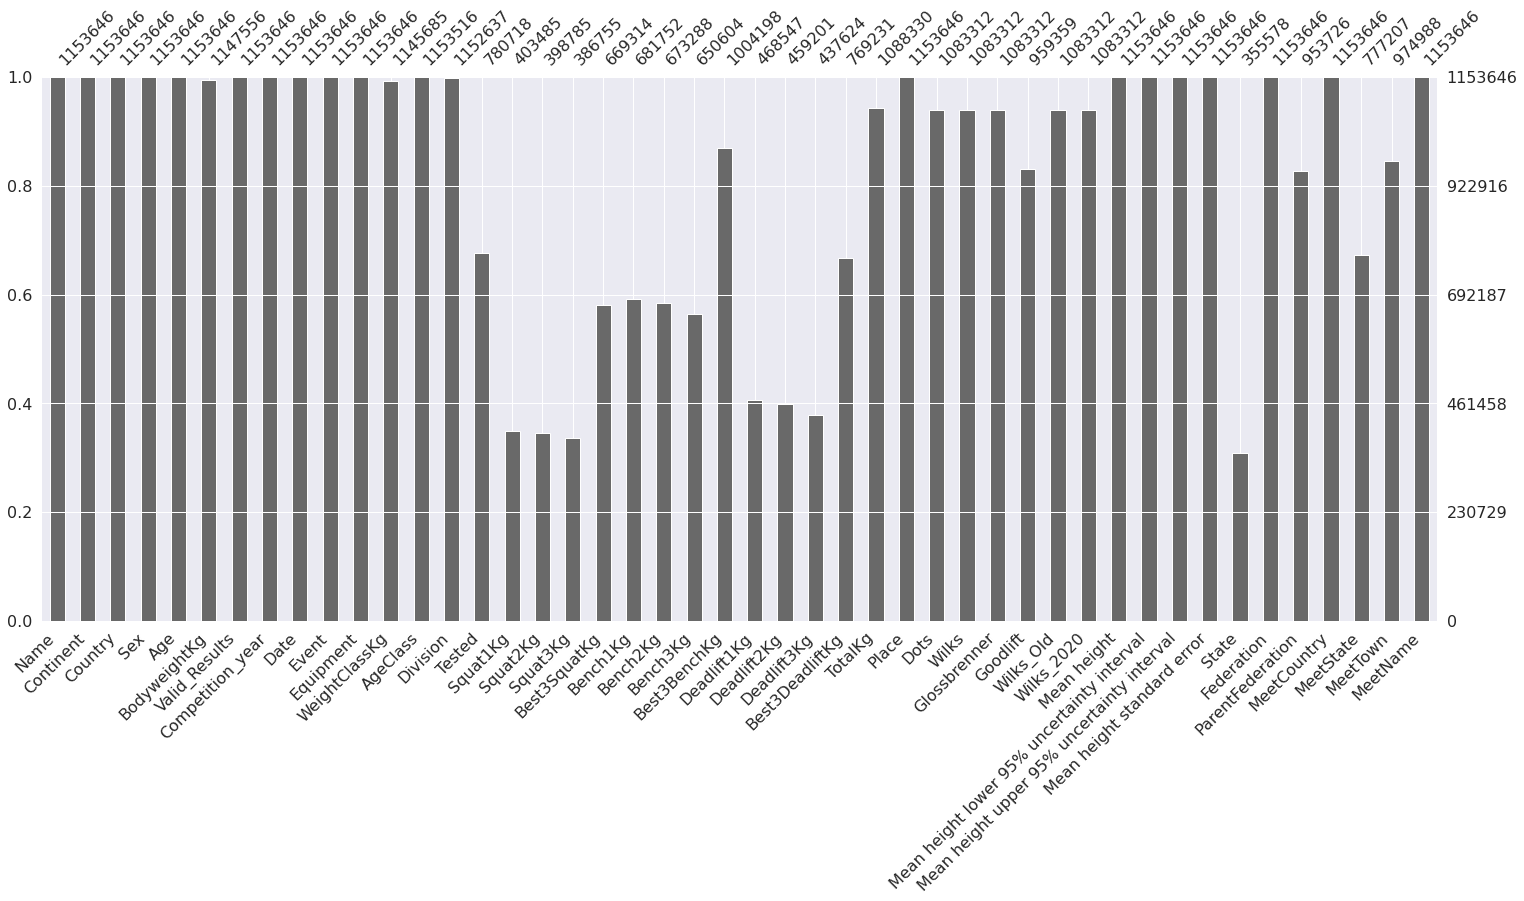

In [35]:
duration_log.add_step('Wrangle - Show distribution of missing features', 'start')
msno.bar(consolidated_dataset)
plt.savefig(OUTPUT_FOLDER + '/barplot_of_missing_features.png')
plt.show()
duration_log.add_step('Wrangle - Show distribution of missing features', 'stop')

##### Matrix view of missing values
Gives a quick overview of how the missing values are distributed among the features

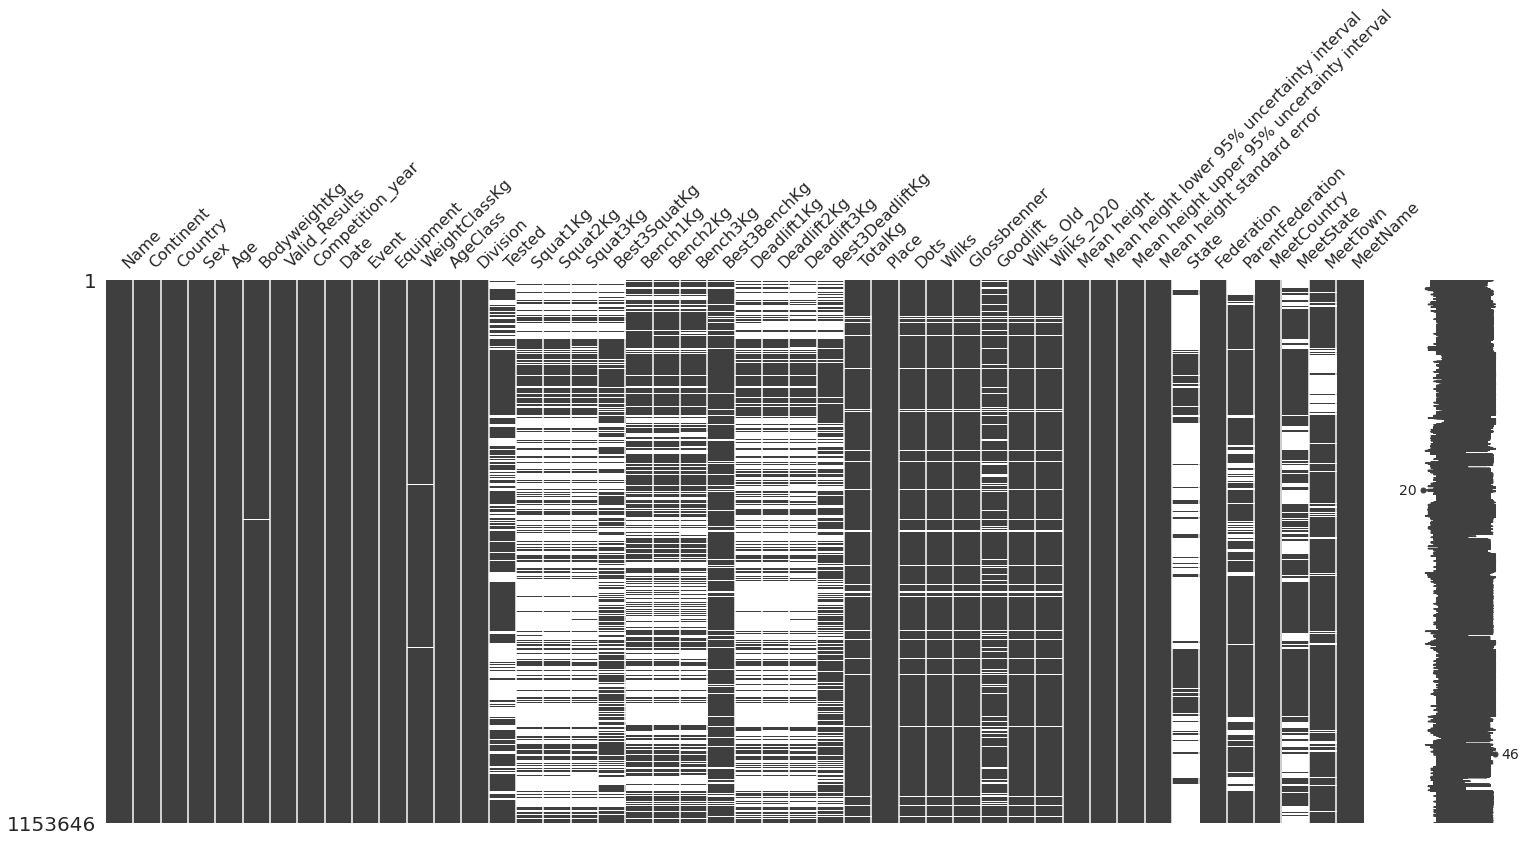

In [36]:
duration_log.add_step('Wrangle - Show Matrixview', 'start')
#sns.heatmap(consolidated_dataset.isnull(), cbar=False)
msno.matrix(consolidated_dataset)
plt.savefig(OUTPUT_FOLDER + '/matrix_view_of_missing_features.png')
plt.show()
duration_log.add_step('Wrangle - Show Matrixview', 'stop')

##### Heatmap of missing values

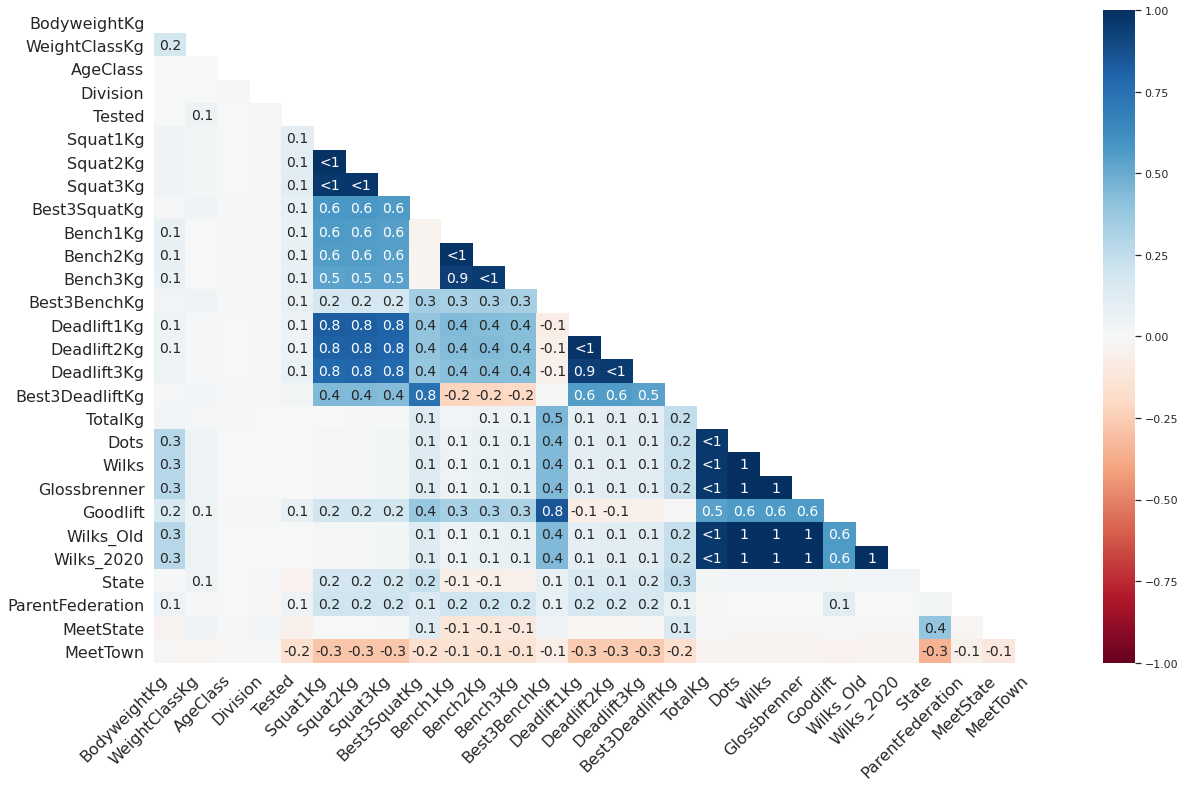

In [37]:
duration_log.add_step('Wrangle - Show heatmap', 'start')
msno.heatmap(consolidated_dataset)
plt.savefig(OUTPUT_FOLDER + '/heatmap_view_of_missing_features.png')
plt.show()
duration_log.add_step('Wrangle - Show heatmap', 'stop')

**Intermediary Conclusion:** We see that we still have a lot of nulls still present. However, they are often in the lifts that werent competed in, or in data that isn't relevant (e.g. state for countries outside of US).
Overall we have enough data to work with

##### Get size information about the dataset

In [38]:
if SHOW_EXPLORATOY_STEP:
    duration_log.add_step('Wrangle - Get final info', 'start')
    consolidated_dataset.info()
    duration_log.add_step('Wrangle - Get final info', 'stop')

#### Distribution of values

##### Types of competition
Let's see how types, federation, and equipment is distributed

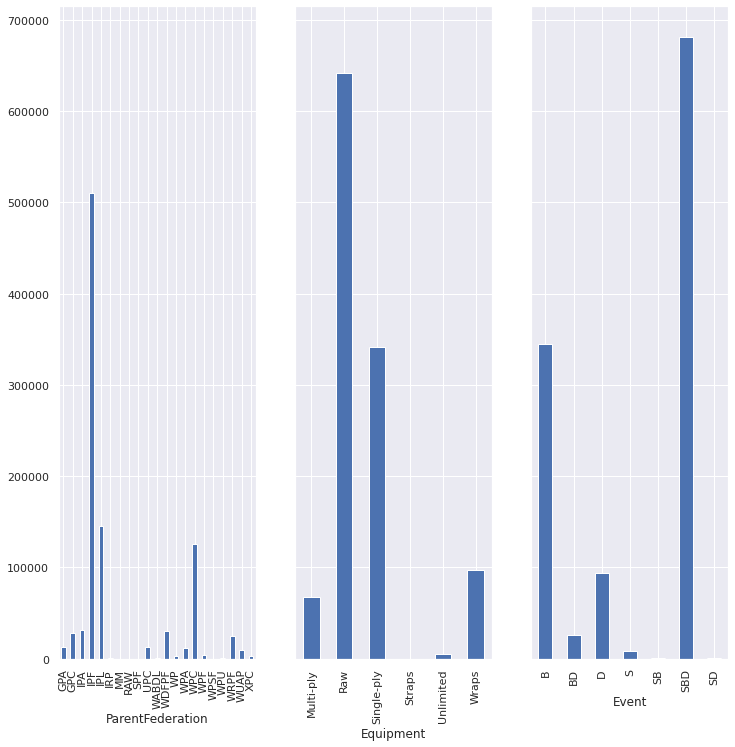

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True,figsize=(12,12))
consolidated_dataset.groupby(['ParentFederation']).Name.count().plot(kind='bar', figsize=(12,12), ax=ax1)
consolidated_dataset.groupby(['Equipment']).Name.count().plot(kind='bar', figsize=(12, 12), ax=ax2)
consolidated_dataset.groupby(['Event']).Name.count().plot(kind='bar', figsize=(12, 12), ax=ax3)
plt.savefig(OUTPUT_FOLDER + '/Distribution_of_competitions.png')
plt.show()

**Intermediary Conclusion:** We see that SBD is most common event, but there is a decent amount of bench-only competitions, which would explain the nulls for deadlift and squat.

Also we see that several equipment-classes are present, but `Raw` is luckily most represented

Similarly, IPF is by far the most used Federation, which was expected

#### Distribution of competitors specs
Next, let's see if the distribution of competitors match what is expected

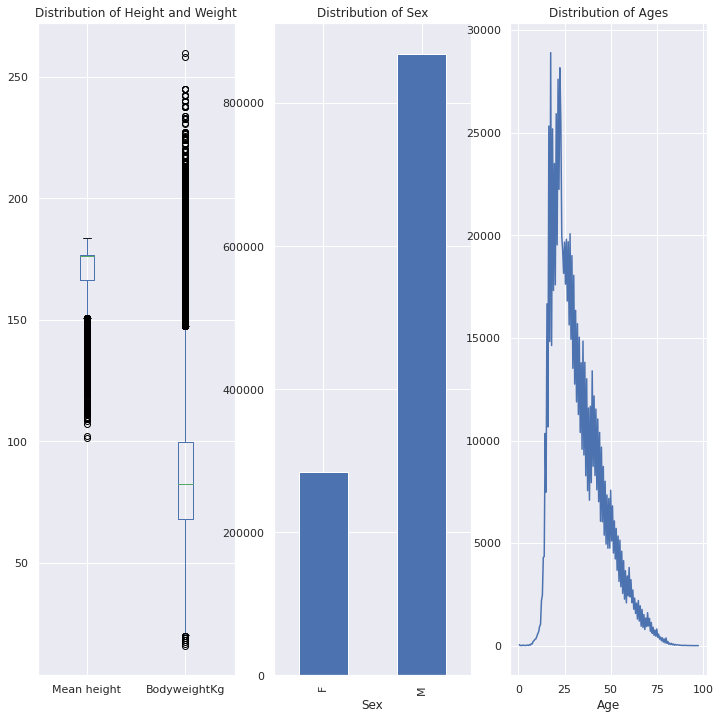

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False,figsize=(12,12))
consolidated_dataset[['Mean height', 'BodyweightKg']].plot(kind="box", ax=ax1)
consolidated_dataset.groupby(['Sex']).Name.count().plot(kind='bar', figsize=(12,12), ax=ax2)
consolidated_dataset.groupby(['Age']).Name.count().plot(kind='line', ax=ax3)
ax1.title.set_text('Distribution of Height and Weight')
ax2.title.set_text('Distribution of Sex')
ax3.title.set_text('Distribution of Ages')
plt.savefig(OUTPUT_FOLDER + '/Distribution_of_competitor_specs.png')

**Intermediary Conclusion:**  We see that height and weight are both within reasonably ranges. Very low values are a mixture between young participants, as well as competitors with physical difficulties, such as amputated legs.

Men are still overrepresented, and there is also a skew in ages.

#### Distribution of Participation
How many, and where are they from? When did they compete?

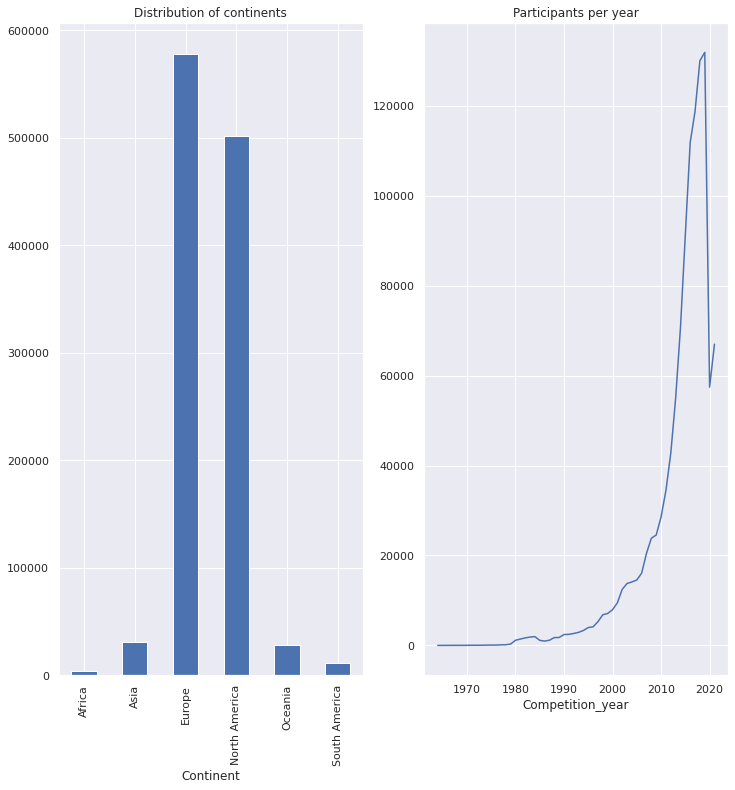

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False,figsize=(12,12))
consolidated_dataset.groupby(['Continent']).Name.count().plot(kind='bar', ax=ax1)
consolidated_dataset.groupby(['Competition_year']).Name.count().plot(kind='line', ax=ax2)
ax1.title.set_text('Distribution of continents')
ax2.title.set_text('Participants per year')
plt.savefig(OUTPUT_FOLDER + '/Participation_amount.png')

**Intermediary Conclusion:** We see that powerlifting is drastically increasing in popularity, but fell steeply as Covid entered. However, it seems to be mainly popular in Europe and North America.

##### Distribution of Participant Performance
Finally, let's take a look at the performance of the participants

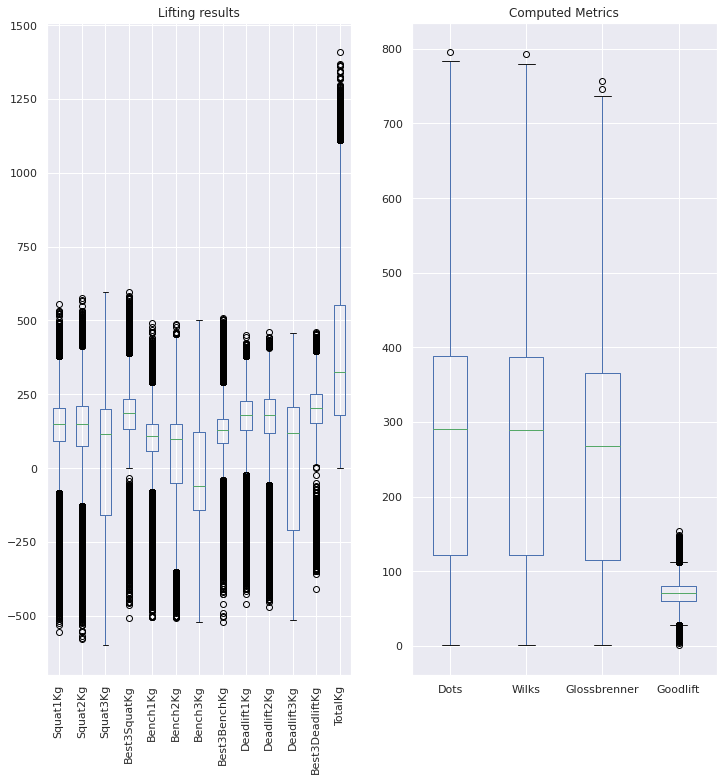

In [42]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False,figsize=(12,12))

consolidated_dataset[['Squat1Kg',
       'Squat2Kg', 'Squat3Kg', 'Best3SquatKg', 'Bench1Kg', 'Bench2Kg',
       'Bench3Kg', 'Best3BenchKg', 'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg',
       'Best3DeadliftKg', 'TotalKg']].plot(kind="box", rot=90, ax=ax1)
consolidated_dataset[['Dots', 'Wilks', 'Glossbrenner', 'Goodlift']].plot(kind="box", ax=ax2)
ax1.title.set_text('Lifting results')
ax2.title.set_text('Computed Metrics')
plt.savefig(OUTPUT_FOLDER + '/Performance.png')

**Intermediary Conclusion:** Both lifts, as well as calculated metrics are all in the reasonable ranges. However we do see some strong outliers for Wotds, Wilks and Glossbrenner, with values that are suspiciouly high, and should be checked.

## Step 2: Profile
_In the Profile stage you need to explore the data in detail, to completely understand its structure, and to discover any interesting patterns that can be found in there._

**Required:**
* _Find at least 3 valueable insights._
* _Show the insights by using visualization._

### Setup
Reread the data, so not entire processing pipeline needs to be done. 

Also do some basic filtering, that would/should have been parameters in the dashboard itself

In [43]:
# Read main dataset
consolidated_dataset = pd.read_csv(OUTPUT_DATASET)
consolidated_dataset = consolidated_dataset.drop('Unnamed: 0',1)

# For Insight 1
Height_Data_Raw = pd.read_csv(HEIGHT_RAW_DATA_PATH)
Height_Data_Raw['Continent'] = Height_Data_Raw.Country.apply(get_continent)

/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (40,42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Insight 1: Development of strength results over time, and the reason behind it
What I was first of all interested in, is to see how the development of average strength has increased over time.

#### Average totals over time
Let's start by looking at the average totals, split by the different lifts vary over time

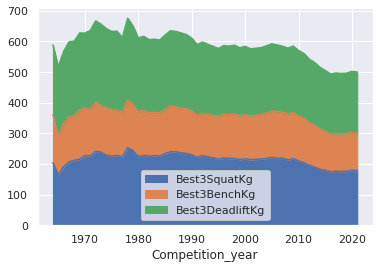

In [44]:
consolidated_dataset.groupby(['Competition_year'])[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']].mean().plot(kind='area')
plt.savefig(OUTPUT_FOLDER + '/i1_ResultsOverTime.png')
plt.show()

**Intermediary Conclusion:** This was not what I was expecting. It seems that the average strength has gone down.
Suspected reason is that in the older times, it was more specialized, meaning only the top level was competing, while in the recent times, it has become more popular, and thus attracts more (and weaker) lifters

#### Development of Wilks over time
One easy way to check if this is the case, is to look at a ranking system, such as Wilks, Dots, or similar. I've chosen Wilks, as that is what I have the most intuitve feeling for.

Let's look at how the Wilks develops over time:

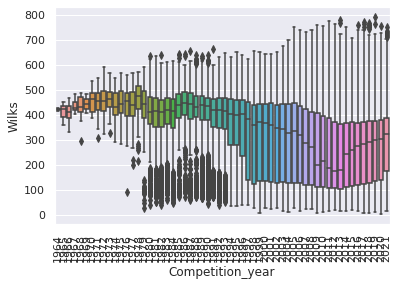

In [45]:
ax = sns.boxplot(data = consolidated_dataset, x='Competition_year',y=('Wilks'))
for item in ax.get_xticklabels():
    item.set_rotation(90)
    
plt.savefig(OUTPUT_FOLDER + '/i1_WilksOverTime.png')
plt.show()

**Intermediary Conclusion:** Wilks does indeed seem to decrease on average. However, we see that the top-outliers (the elite) still seems to be increasing. This furthers our hypothesis that the decrease in results might be reasoned by the increased popularity

#### Reason for decrease in Wilks?
As Wilks is a measure in relativity between bodyweight and lifted weight, this can either decrease if the average lifts go down, or the average weight has gone up.
Let's therefore take a look at how the bodyweight of competitors have changed over time

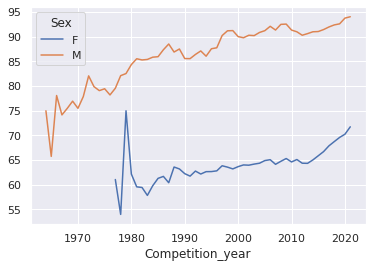

In [46]:
consolidated_dataset.groupby(['Competition_year', 'Sex']).BodyweightKg.mean().unstack(level=1).plot(kind='line')
plt.savefig(OUTPUT_FOLDER + '/i1_weightOverTime.png')
plt.show()

**Intermediary Conclusion:** We do see an increase over time. However, that would not be dramatic enough for the differences we are seeing.

#### Bombing out!
Now It clicked! Bombed out attempts are still included in the dataset, and are displayed with negative values. Let's take a look at whether we see a large increase in bomed out attempts

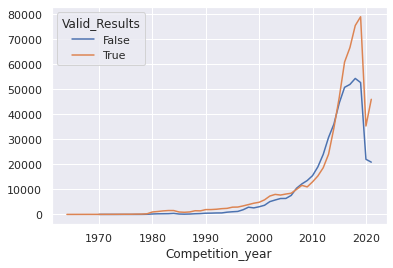

In [47]:
consolidated_dataset.groupby(['Competition_year', 'Valid_Results']).Name.count().unstack(level=1).plot(kind='line')
plt.savefig(OUTPUT_FOLDER + '/i1_ParticipantsOverTime.png')
plt.show()

**Intermediate Conclusion:** Indeed we do! We see a sharp increase, and it is therefore worthwhile to remove these

#### Change in Wilks after removing "Bombed out"
Finally, lets visualize the change in wilks, after having filtered out these entries, and thus are only left with realistic measures for the strength of participants

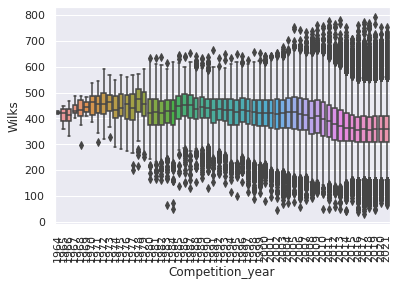

In [48]:
valid_res = consolidated_dataset[consolidated_dataset['Valid_Results'] == True].copy()
ax = sns.boxplot(data = valid_res, x='Competition_year',y=('Wilks'))
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.savefig(OUTPUT_FOLDER + '/i1_ResultsOverTime_Filtered.png')
plt.show()


**Intermediary Conclusion:** Now we see a decrease, that seems fitting to the participants' bodyweight increase. We see that overall, the top outliers seem to increase, while the average competitor has a strength closer to the population "average" - 300 Wilks is a "normal gym-strong person"

#### Conclusion
We see that over time the elite in powerlifting is indeed becoming stronger. However, the increased amount of participants is so much greater, that the mean of the results get close to "normal-person-strong". We can therefore compare the strength-averages with the height-averages of the countries.

### Insight 2: Changes in height over time
Not sure if this is considered cheating, but decided to go for the raw dataset of height here. Reason for not using the consolidated dataset, is due to the class imbalance between the continents, as powerlifting seems to be more popular in Europe and Northern America, and I wanted to see the world-wide development without this bias.

Aiming to use these insights for insight three, where I am going back to the consolidated dateset.

#### Look at height development per continent and gender

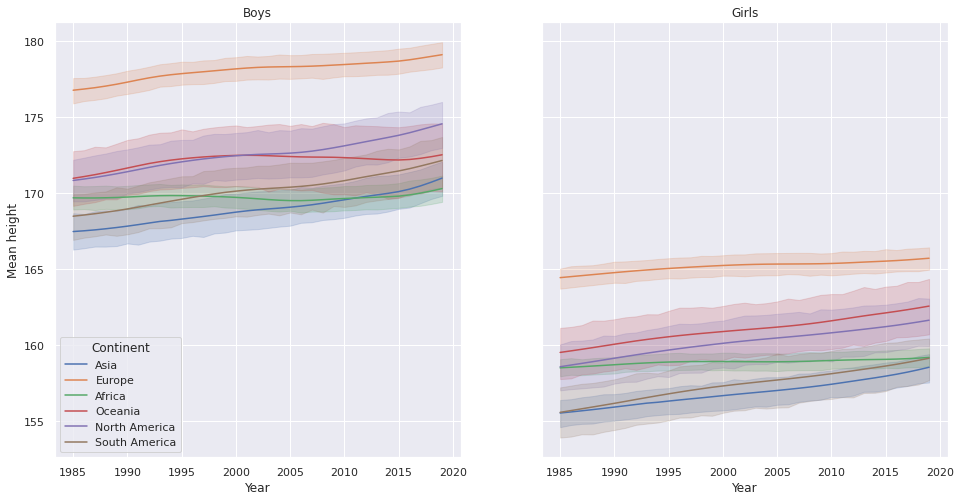

In [49]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(16,8))

mask = ((Height_Data_Raw['Age group'] == 19) & (Height_Data_Raw['Sex'] == 'Boys'))
dat = Height_Data_Raw[mask]
sns.lineplot(x='Year'
           , y='Mean height'
           , hue="Continent"
             , data=dat
             , ax=ax1
          )

mask = ((Height_Data_Raw['Age group'] == 19) & (Height_Data_Raw['Sex'] == 'Girls'))
dat = Height_Data_Raw[mask]

sns.lineplot(x='Year'
           , y='Mean height'
           , hue="Continent"
           , data=dat
           , ax=ax2
          )
#ax1.get_legend().remove()
ax2.get_legend().remove()
ax1.title.set_text('Boys')
ax2.title.set_text('Girls')
plt.savefig(OUTPUT_FOLDER + '/i2_height_over_time.png')
plt.show()

**Intermediary Conclusion:** Not surprising, but Europe and Northern America seems to be in the lead with being tallest, and men are taller than women.

#### Comparing first and last year

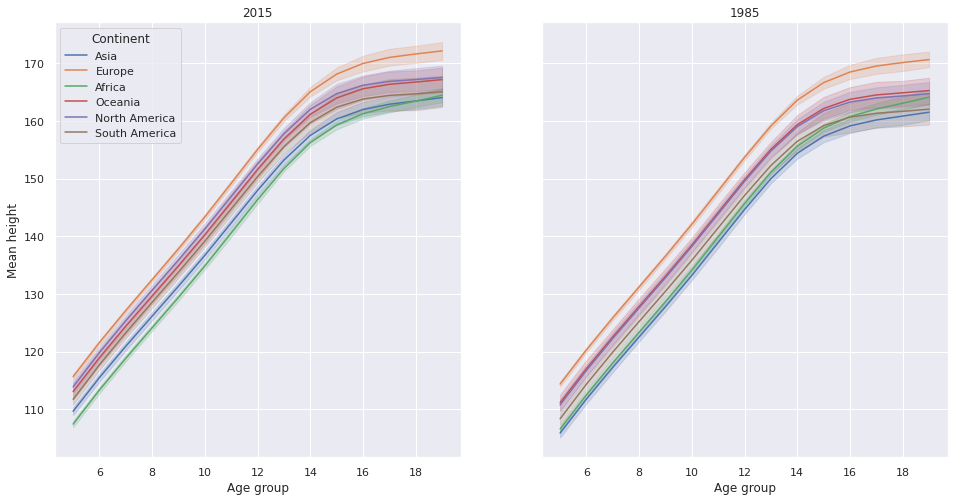

In [50]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(16,8))

mask = ((Height_Data_Raw['Year'] == 2015))
dat = Height_Data_Raw[mask]
sns.lineplot(x='Age group'
           , y='Mean height'
           #, hue="Country"
           , hue="Continent"
           #, fit_reg=False
           #, col = 'Sex'
           , data=dat
             , ax=ax1
          )

mask = ((Height_Data_Raw['Year'] == 1985))
dat = Height_Data_Raw[mask]
sns.lineplot(x='Age group'
           , y='Mean height'
           #, hue="Country"
           , hue="Continent"
           #, fit_reg=False
           #, col = 'Sex'
           , data=dat
             , ax=ax2
          )
#ax1.get_legend().remove()
ax2.get_legend().remove()
ax1.title.set_text('2015')
ax2.title.set_text('1985')
plt.savefig(OUTPUT_FOLDER + '/i2_height_over_age.png')
plt.show()

**Intermediary Conclusion:** The difference is way less noticeable than expected

#### Different ages for puperty?

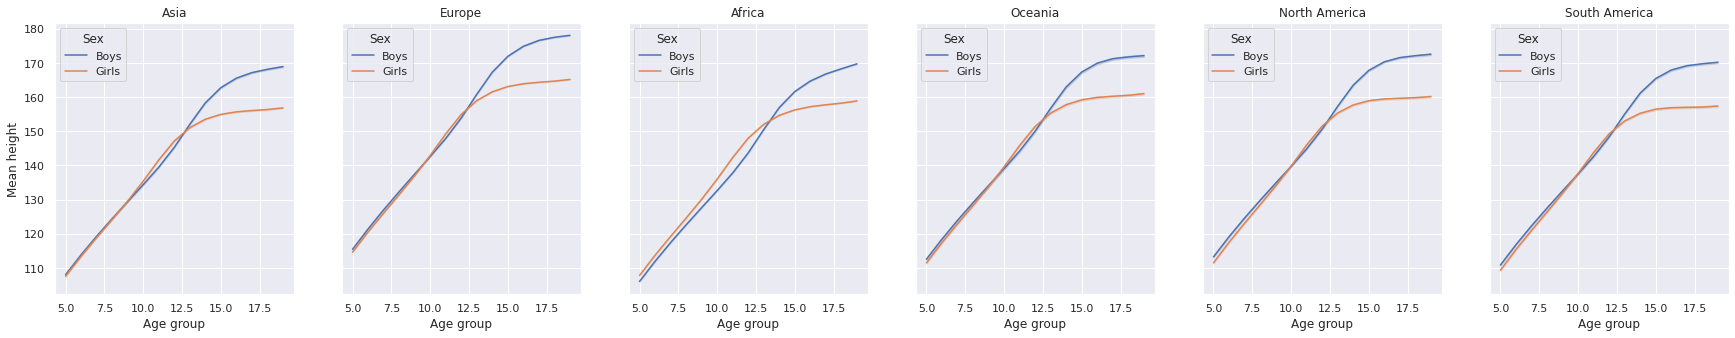

In [51]:
# What an absolutely horrible way to visualize this!
## Refactor!!!!
fig, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(ncols=6, sharey=True,figsize=(30,5))

mask = ((Height_Data_Raw['Continent'] == 'Asia'))
dat = Height_Data_Raw[mask]
sns.lineplot(x='Age group'
           , y='Mean height'
           , hue="Sex"
           , data=dat
           , ax=ax1
          )
mask = ((Height_Data_Raw['Continent'] == 'Europe'))
dat = Height_Data_Raw[mask]
sns.lineplot(x='Age group'
           , y='Mean height'
           , hue="Sex"
           , data=dat
           , ax=ax2
          )
mask = ((Height_Data_Raw['Continent'] == 'Africa'))
dat = Height_Data_Raw[mask]
sns.lineplot(x='Age group'
           , y='Mean height'
           , hue="Sex"
           , data=dat
           , ax=ax3
          )
mask = ((Height_Data_Raw['Continent'] == 'Oceania'))
dat = Height_Data_Raw[mask]
sns.lineplot(x='Age group'
           , y='Mean height'
           , hue="Sex"
           , data=dat
           , ax=ax4
          )
mask = ((Height_Data_Raw['Continent'] == 'North America'))
dat = Height_Data_Raw[mask]
sns.lineplot(x='Age group'
           , y='Mean height'
           , hue="Sex"
           , data=dat
           , ax=ax5
          )
mask = ((Height_Data_Raw['Continent'] == 'South America'))
dat = Height_Data_Raw[mask]
sns.lineplot(x='Age group'
           , y='Mean height'
           , hue="Sex"
           , data=dat
           , ax=ax6
          )
ax1.title.set_text('Asia')
ax2.title.set_text('Europe')
ax3.title.set_text('Africa')
ax4.title.set_text('Oceania')
ax5.title.set_text('North America')
ax6.title.set_text('South America')
plt.show()

**Intermediary Conclusion:** I'm really not sure... Can we see anything worthwile?

#### Conclusion
I'm a bit dissappointed in this one. We don't see anything in this data, that we didn't really know beforehand. Insights gained:
* Boys are taller than girls
* There is a brief period where girls are taller than boys, but the boys overtake them again after puperty hits.
* There is a slight difference in height depending on continent.
* The growth rate seems to be very uniform across continents.

### Insight 3: Correlation between height, weight and performance
This part is still very rough!!! - Needs reworking

#### Get a feel for the distributions

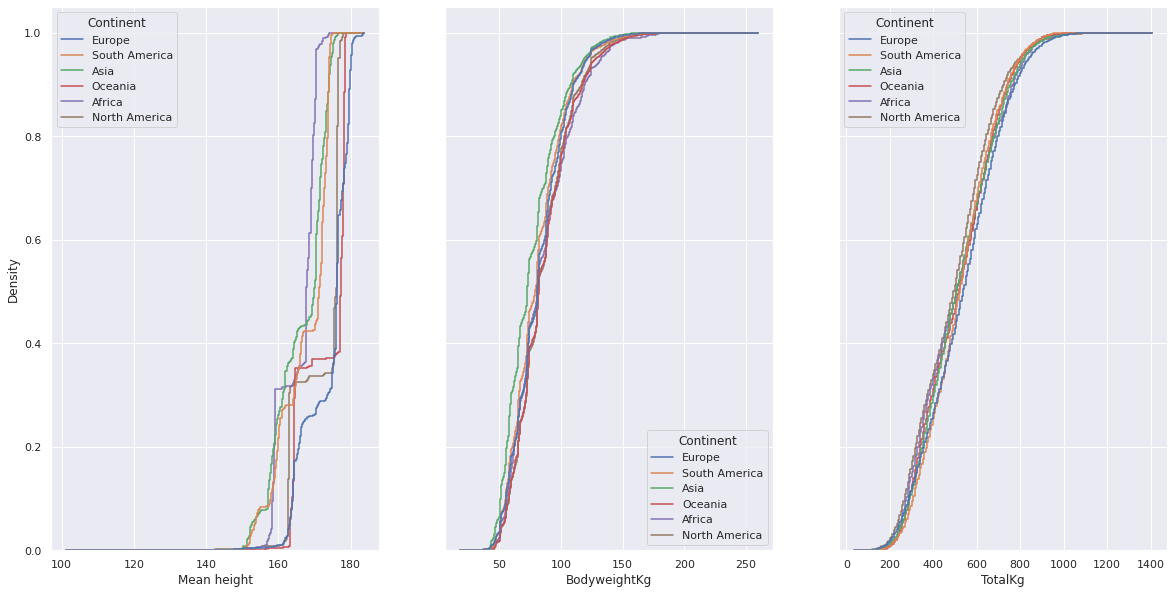

In [52]:
fig, axs = plt.subplots(ncols=3, sharey=True,figsize=(20,10))


sns.histplot(data=valid_res
             , x='Mean height'
             , hue='Continent'
             ,log_scale=False
             , element="step"
             , fill=False
             , cumulative=True
             , stat="density"
             , common_norm=False
             , ax = axs[0]
            )

sns.histplot(data=valid_res
             , x='BodyweightKg'
             , hue='Continent'
             ,log_scale=False
             , element="step"
             , fill=False
             , cumulative=True
             , stat="density"
             , common_norm=False
             , ax = axs[1]
            )

sns.histplot(data=valid_res
             , x='TotalKg'
             , hue='Continent'
             ,log_scale=False
             , element="step"
             , fill=False
             , cumulative=True
             , stat="density"
             , common_norm=False
             , ax = axs[2]
            )

plt.savefig(OUTPUT_FOLDER + '/i3_dist.png')
plt.show()

**Intermediary Conclusion:** Not a whole lot so far. We see that the distributions for the entire populations are quite well behaved. This doesn't tell us anything about the correlation though

#### Scatter plot to see interaction

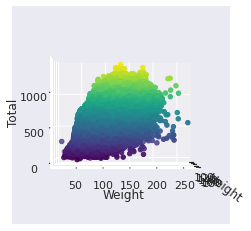

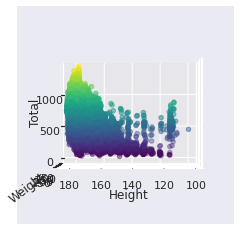

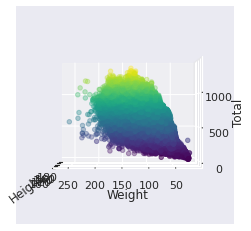

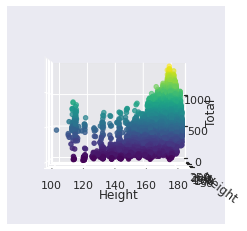

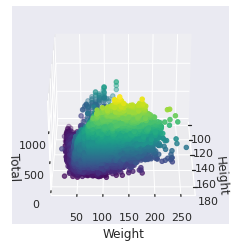

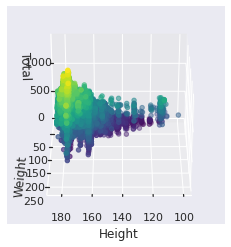

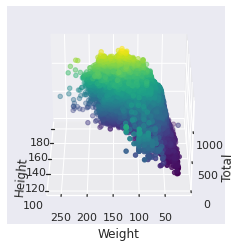

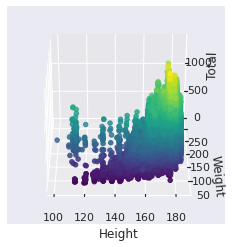

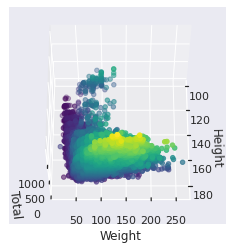

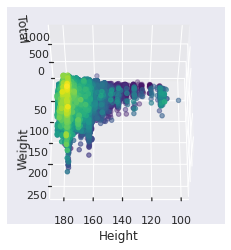

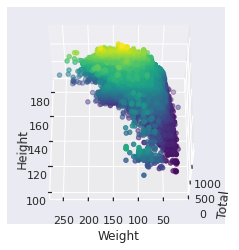

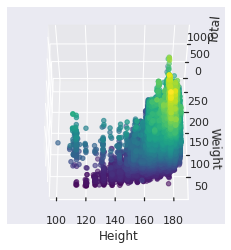

In [53]:
for height in [0,30,60]:
    for angle in range(0, 360, 90):
        fig = plt.figure()
        ax = fig.add_subplot(111,projection='3d')
        ax.set_xlabel('Height')
        ax.set_ylabel('Weight')
        ax.set_zlabel('Total')
        ax.scatter3D(valid_res['Mean height'], valid_res['BodyweightKg'], valid_res['TotalKg'], c=valid_res['TotalKg'], cmap='viridis');
        ax.view_init(height, angle)
        plt.savefig(f'{OUTPUT_FOLDER}/i3_3d_h{height}_a{angle}.png', bbox_inches='tight')
        plt.show()


**Intermediary Conclusion:** Rotating around and playing with this visualization, seems to show quite well how the three variables interact; All three variables seem to correlate quite well.
However, as this isn't report friendly, lets try to see if we can do some dimensional reduction

#### Comparing two variables at a time
This might be more report friendly. So much so, that I decided to reuse these in the bonus insight later

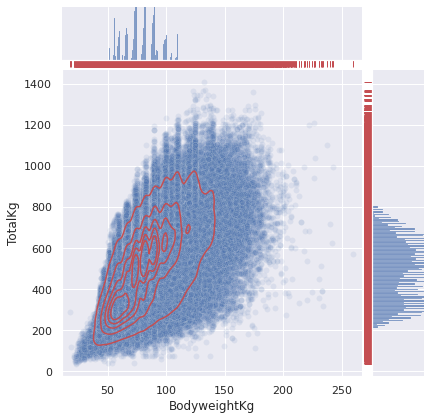

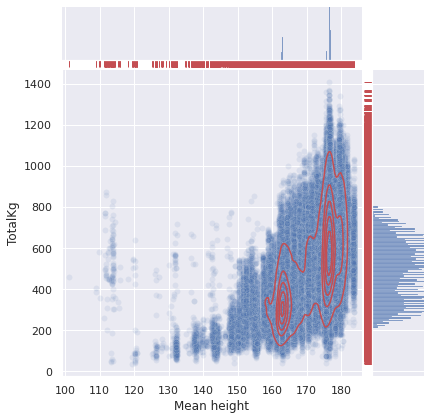

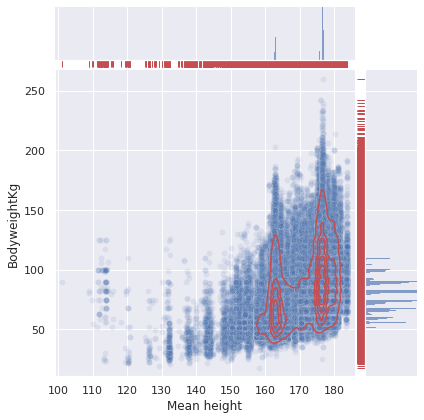

In [54]:
## Bodyweight vs Lifted weight
g = sns.jointplot(data=valid_res, x="BodyweightKg", y="TotalKg", alpha=0.1)
g.plot_joint(sns.kdeplot, color="r", zorder=3, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_WeightVsLift')
plt.show()

## Mean Height vs Lifted weight
g = sns.jointplot(data=valid_res, x="Mean height", y="TotalKg", alpha=0.1)
g.plot_joint(sns.kdeplot, color="r", zorder=3, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_HeightVsLift')
plt.show()

## Bodyweight vs Mean Height
g = sns.jointplot(data=valid_res, x="Mean height", y="BodyweightKg", alpha=0.1)
g.plot_joint(sns.kdeplot, color="r", zorder=3, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_WeightVsHeight')
plt.show()

**Conclusion:** We do see that these three variables are correlated

### Bonus Insights; various groupings
These are to be added as appendicies to the report, as I found it interesting. However not enough so, to be called a main insight.

#### Sex

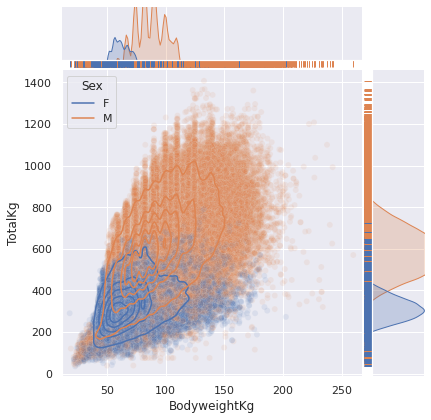

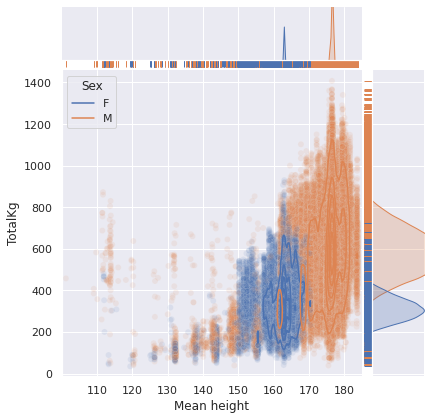

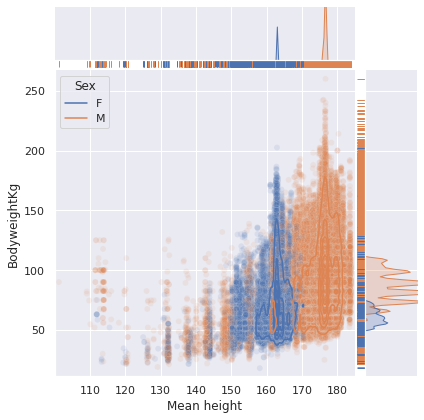

In [55]:
group = "Sex"
## Bodyweight vs Lifted weight
g = sns.jointplot(data=valid_res, x="BodyweightKg", y="TotalKg", hue=group, alpha=0.1)
g.plot_joint(sns.kdeplot, color="r", hue=group, zorder=3, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_WeightVsLift')
plt.show()

## Mean Height vs Lifted weight
g = sns.jointplot(data=valid_res, x="Mean height", y="TotalKg", hue=group, alpha=0.1)
g.plot_joint(sns.kdeplot, color="r", hue=group, zorder=3, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_HeightVsLift')
plt.show()

## Bodyweight vs Mean Height
g = sns.jointplot(data=valid_res, x="Mean height", y="BodyweightKg", hue=group, alpha=0.1)
g.plot_joint(sns.kdeplot, color="r", hue=group, zorder=3, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_WeightVsHeight')
plt.show()

**Intermediary Conclusion:** Difference exists quite clearly

#### Continent

/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
<ipython-input-56-1d6d8a4dae56>:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_WeightVsLift')
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


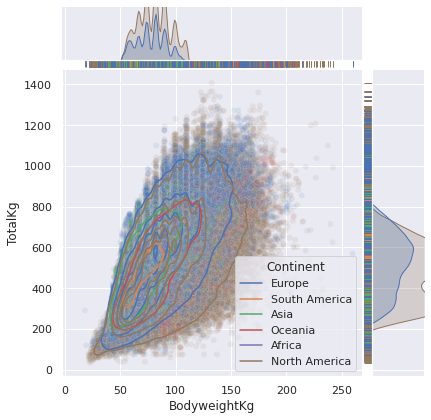

/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


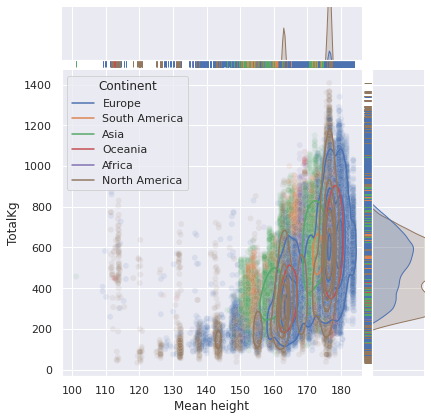

/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


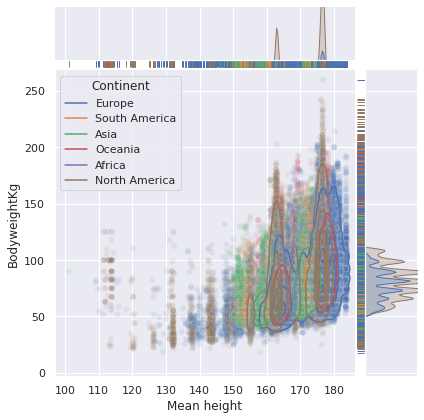

In [56]:
group = "Continent"
## Bodyweight vs Lifted weight
g = sns.jointplot(data=valid_res, x="BodyweightKg", y="TotalKg", hue=group, alpha=0.1)
g.plot_joint(sns.kdeplot, color="r", hue=group, zorder=3, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_WeightVsLift')
plt.show()

## Mean Height vs Lifted weight
g = sns.jointplot(data=valid_res, x="Mean height", y="TotalKg", hue=group, alpha=0.1)
g.plot_joint(sns.kdeplot, color="r", hue=group, zorder=3, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_HeightVsLift')
plt.show()

## Bodyweight vs Mean Height
g = sns.jointplot(data=valid_res, x="Mean height", y="BodyweightKg", hue=group, alpha=0.1)
g.plot_joint(sns.kdeplot, color="r", hue=group, zorder=3, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_WeightVsHeight')
plt.show()

**Intermediary Conclusion:** Not really

#### Equipment

/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
<ipython-input-57-322233a5e16f>:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_WeightVsLift')
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:

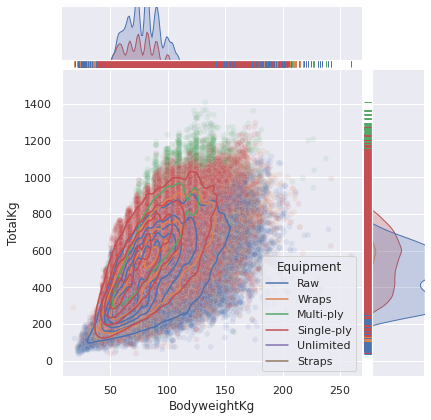

/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


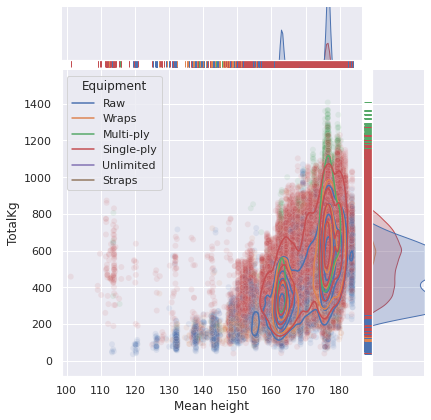

/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


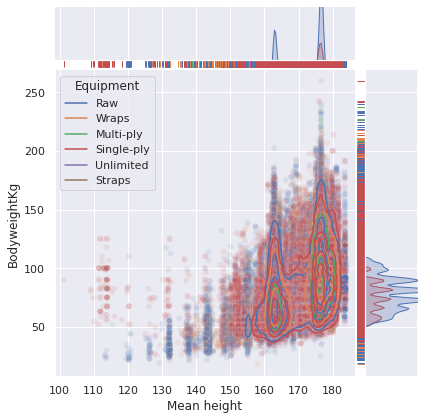

In [57]:
group = 'Equipment'
## Bodyweight vs Lifted weight
g = sns.jointplot(data=valid_res, x="BodyweightKg", y="TotalKg", hue=group, alpha=0.1)
g.plot_joint(sns.kdeplot, color="r", hue=group, zorder=3, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_WeightVsLift')
plt.show()

## Mean Height vs Lifted weight
g = sns.jointplot(data=valid_res, x="Mean height", y="TotalKg", hue=group, alpha=0.1)
g.plot_joint(sns.kdeplot, color="r", hue=group, zorder=3, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_HeightVsLift')
plt.show()

## Bodyweight vs Mean Height
g = sns.jointplot(data=valid_res, x="Mean height", y="BodyweightKg", hue=group, alpha=0.1)
g.plot_joint(sns.kdeplot, color="r", hue=group, zorder=3, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_WeightVsHeight')
plt.show()

**Intermediary Conclusion:** Nothing exciting to see here. Raw tends to emcompas a broader range of height/weight, and also with a lower score

#### Tested

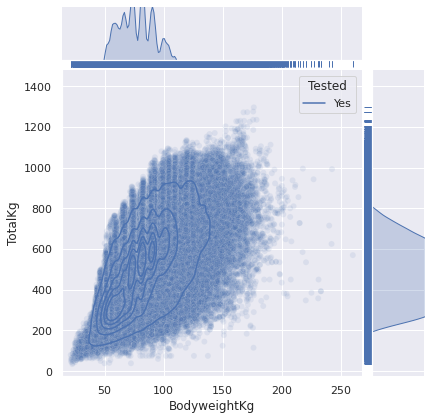

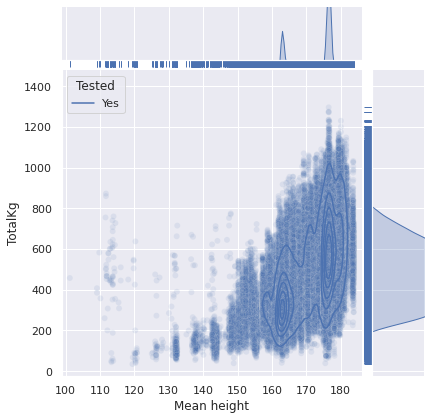

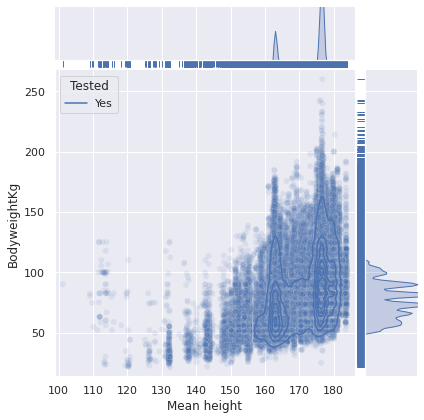

In [58]:
group = 'Tested'
## Bodyweight vs Lifted weight
g = sns.jointplot(data=valid_res, x="BodyweightKg", y="TotalKg", hue=group, alpha=0.1)
g.plot_joint(sns.kdeplot, color="r", hue=group, zorder=3, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_WeightVsLift')
plt.show()

## Mean Height vs Lifted weight
g = sns.jointplot(data=valid_res, x="Mean height", y="TotalKg", hue=group, alpha=0.1)
g.plot_joint(sns.kdeplot, color="r", hue=group, zorder=3, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_HeightVsLift')
plt.show()

## Bodyweight vs Mean Height
g = sns.jointplot(data=valid_res, x="Mean height", y="BodyweightKg", hue=group, alpha=0.1)
g.plot_joint(sns.kdeplot, color="r", hue=group, zorder=3, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_WeightVsHeight')
plt.show()

**Intermediary Conclusion:** 
Weird... I seem to have filtered out all the non-tested lifts...

#### Parent Federation

In [60]:
group = 'ParentFederation'

<ipython-input-64-f9ad0f63a492>:6: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_WeightVsLift')
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


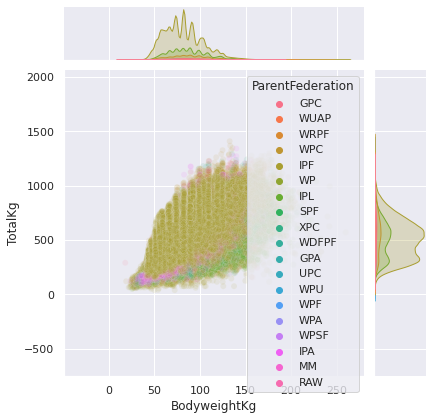

In [64]:
## Bodyweight vs Lifted weight
g = sns.jointplot(data=valid_res, x="BodyweightKg", y="TotalKg", hue=group, alpha=0.1)
#g.plot_joint(sns.kdeplot, color="r", hue=group, zorder=3, levels=6)
#g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_WeightVsLift')
plt.show()

<ipython-input-65-ef115d3efacf>:6: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_HeightVsLift')
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


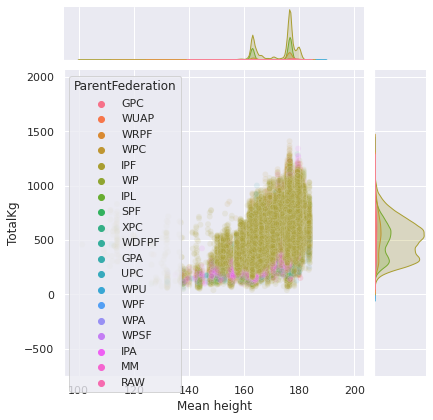

In [65]:
## Mean Height vs Lifted weight
g = sns.jointplot(data=valid_res, x="Mean height", y="TotalKg", hue=group, alpha=0.1)
#g.plot_joint(sns.kdeplot, color="r", hue=group, zorder=3, levels=6)
#g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_HeightVsLift')
plt.show()

<ipython-input-66-a74b03999e37>:6: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_WeightVsHeight')
/home/waxfactor2nd/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


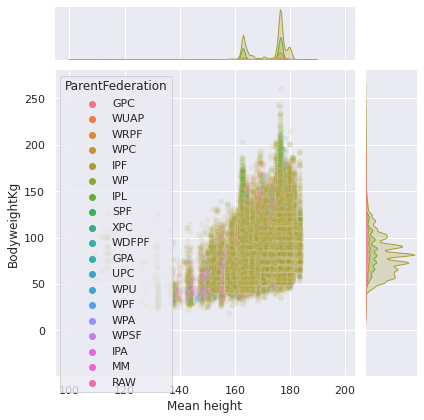

In [66]:
## Bodyweight vs Mean Height
g = sns.jointplot(data=valid_res, x="Mean height", y="BodyweightKg", hue=group, alpha=0.1)
#g.plot_joint(sns.kdeplot, color="r", hue=group, zorder=3, levels=6)
#g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

plt.savefig(f'{OUTPUT_FOLDER}/i3_group_{group}_WeightVsHeight')
plt.show()

**Intermediary Conclusion:** Something here breaks, and not sure why

## Conclusion
Overall we did a thing, and then stuff and things

Finally, again not strictly part of this assignment, but I'd like to see which steps took time:

In [67]:
duration_log.show_log()

,Stepname,start,end,duration
0,Read in Openpowerlifting CSV,2021-12-19 14:27:11.469988,2021-12-19 14:27:18.328997,0 days 00:00:06.859009
0,Read in height CSV,2021-12-19 14:27:18.334284,2021-12-19 14:27:18.451698,0 days 00:00:00.117414
0,Exploratory Data Analysis - Openpowerlifting,2021-12-19 14:27:18.457468,2021-12-19 14:27:18.530447,0 days 00:00:00.072979
0,Exploratory Data Analysis - Height,2021-12-19 14:27:18.544794,2021-12-19 14:27:18.587223,0 days 00:00:00.042429
0,Wrangle OPL - Clone,2021-12-19 14:27:18.601549,2021-12-19 14:27:18.882227,0 days 00:00:00.280678
0,Wrangle OPL - drop 4th attempts,2021-12-19 14:27:18.888142,2021-12-19 14:27:19.260037,0 days 00:00:00.371895
0,Wrangle OPL - drop missing age,2021-12-19 14:27:19.279893,2021-12-19 14:27:19.640343,0 days 00:00:00.360450
0,Wrangle OPL - filter sex,2021-12-19 14:27:19.646967,2021-12-19 14:27:20.351963,0 days 00:00:00.704996
0,Wrangle OPL - filter Country,2021-12-19 14:27:20.354532,2021-12-19 14:27:21.053069,0 days 00:00:00.698537
0,Wrangle OPL - Add Wilks Old,2021-12-19 14:27:21.066194,2021-12-19 14:27:43.123797,0 days 00:00:22.057603


Insights are concluded under each section